In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualization
import matplotlib.pyplot as plt
import random
import numpy.random as rn

from sklearn.metrics import accuracy_score, log_loss
from scipy import optimize
from keras import losses
from keras import backend as K
import tensorflow as tf
from sklearn import neural_network

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import *
from keras.wrappers.scikit_learn import KerasClassifier
import keras
from keras import losses
from functools import partial
import math

%matplotlib notebook

Using TensorFlow backend.


# Preprocessing

In [2]:
data = pd.read_csv('leaf.csv', header=None)
data.drop([1],inplace=True,axis=1)
X = data.values[:,1:]
Y_first = data.values[:,0]
Y = []
out = np.zeros(shape=[36])
for i in range(np.shape(Y_first)[0]):
    out[int(Y_first[i])-1]=1
    Y.append(out)
    out = np.zeros(shape=[36])
Y = np.array(Y)
# min_max_scaler = preprocessing.MinMaxScaler()
# X_scaled = min_max_scaler.fit_transform(X)
# df_normalized = pd.DataFrame(X_scaled)

r,c = np.shape(X)

total_samples = list(np.arange(0,r,1))
test_samples = random.sample(total_samples,int(np.round(len(total_samples)*0.2)))
train_samples = list(set(total_samples) - set(test_samples))

# Splitting Data

In [3]:
# trainX = X[train_samples]
# trainX_scaled = (trainX-np.min(trainX))/(np.max(trainX)-np.min(trainX))
# trainY = Y[train_samples]
# trainY_comp = Y_first[train_samples]

# testX = X[test_samples]
# testX_scaled = (testX-np.min(testX))/(np.max(testX)-np.min(testX))
# testY = Y[test_samples]
# testY_comp = Y_first[test_samples]
# print(len(trainX[0]))
# print(len(trainY[0]))

In [67]:
trainX = np.load('trainX.npy')
trainY = np.load('trainY.npy')
trainY_comp = np.load('trainY_comp.npy')

testX = np.load('testX.npy')
testY = np.load('testY.npy')
testY_comp = np.load('testY_comp.npy')

trainX_val= np.load('trainX_val.npy')
trainY_val=np.load('trainY_val.npy')
trainY_comp_val=np.load('trainY_comp_val.npy')

#  Neural Network

In [126]:
def nn_objective_train(x_u):
    num_inputs = 14
    num_outputs = 36

    hidden_layer_neurons = 405
    x = x_u[0]
    weights_all = num_inputs*hidden_layer_neurons + hidden_layer_neurons*num_outputs
    bias_all = hidden_layer_neurons+num_outputs
    iw_size = num_inputs*hidden_layer_neurons
    nn_weights = x[:weights_all]
    bias_all = x[weights_all:]
    iw = nn_weights[0:iw_size]
    ow = nn_weights[iw_size:]
    b1 = bias_all[:hidden_layer_neurons]
    b2 = bias_all[hidden_layer_neurons:]
    w1 = np.reshape(iw,(num_inputs, hidden_layer_neurons))
    w2 = np.reshape(ow,(hidden_layer_neurons, num_outputs))
    l1 = np.maximum(np.dot(trainX, w1)+b1, 0)
    x_i = np.dot(l1, w2)+b2
    l2 = np.array(np.exp(x_i)/ np.exp(x_i).sum(axis=1)[:,None])  
    l2_act = np.argmax(l2,axis=1)+1
    output = np.clip(l2, 1e-15, 1. - 1e-15)
    er= -np.sum(trainY * np.log(output))
    return er

def nn_objective_val(x_u):
    num_inputs = 14
    num_outputs = 36

    hidden_layer_neurons = 405
    x = x_u[0]
    weights_all = num_inputs*hidden_layer_neurons + hidden_layer_neurons*num_outputs
    bias_all = hidden_layer_neurons+num_outputs
    iw_size = num_inputs*hidden_layer_neurons
    nn_weights = x[:weights_all]
    bias_all = x[weights_all:]
    iw = nn_weights[0:iw_size]
    ow = nn_weights[iw_size:]
    b1 = bias_all[:hidden_layer_neurons]
    b2 = bias_all[hidden_layer_neurons:]
    w1 = np.reshape(iw,(num_inputs, hidden_layer_neurons))
    w2 = np.reshape(ow,(hidden_layer_neurons, num_outputs))
    l1 = np.maximum(np.dot(trainX_val, w1)+b1, 0)
    x_i = np.dot(l1, w2)+b2
    l2 = np.array(np.exp(x_i)/ np.exp(x_i).sum(axis=1)[:,None])  
    l2_act = np.argmax(l2,axis=1)+1
    output = np.clip(l2, 1e-15, 1. - 1e-15)
    er= -np.sum(trainY_val * np.log(output))
    return er



# SA

In [127]:
def annealing(random_start,
              cost_function,
              random_neighbour,
              acceptance_probability,
              temperature,
              maxsteps,
              debug,starting_point,ep,f_min):
    """ Optimize the black-box function 'cost_function' with the simulated annealing algorithm."""
    state = random_start()
    cost = cost_function(state)
    cost_val = nn_objective_val(state)
    costs_val = [cost_val]
    if np.isnan(costs_val):
        costs_val = [20000.]
    states, costs = [state], [cost]
    for step in range(maxsteps):
        fraction = step / float(maxsteps)
        T = temperature(fraction,starting_point,ep)
        new_state = random_neighbour(state, fraction,f_min)
        new_cost = cost_function(new_state)
        new_cost_val = nn_objective_val(new_state)
        #if debug: print("Step #{:>2}/{:>2} : T = {:>4.3g}, state = {:>4.3g}, cost = {:>4.3g}, new_state = {:>4.3g}, new_cost = {:>4.3g} ...".format(step, maxsteps, T, state, cost, new_state, new_cost))
        if acceptance_probability(cost, new_cost, T) > rn.random():
            state, cost = new_state, new_cost
            cost_val = new_cost_val
            costs_val.append(cost_val)
            states.append(state)
            costs.append(cost)
        else:
            costs_val.append(cost_val)
            costs.append(cost)
            
            # print("  ==> Accept it!")
        # else:
        #    print("  ==> Reject it...")
    return state, cost_function(state),cost_val, states, costs, costs_val

def clip(x):
    """ Force x to be in the interval."""
    
    a, b = interval
    return np.clip(x, a, b)
#     return max(min(x, b), a)

def random_start():
    """ Random point in the interval."""
    a, b = interval
    return a + (b - a) * np.random.random((1,tw))

def cost_function(x):
    """ Cost of x = f(x)."""
    return nn_objective(x)

def random_neighbour(x, fraction,f_min):
    """Move a little bit x, from the left or the right."""
    amplitude = (max(interval) - min(interval)) * fraction / f_min
    delta = (-amplitude/2.) + amplitude * np.random.random((1,tw))
    #delta = f_min* np.random.random((1,tw))
    return clip(x + delta)


def acceptance_probability(cost, new_cost, temperature):
    if new_cost < cost:
        # print("    - Acceptance probabilty = 1 as new_cost = {} < cost = {}...".format(new_cost, cost))
        return 1
    else:
        p = np.exp(- (new_cost - cost) / temperature)
        # print("    - Acceptance probabilty = {:.3g}...".format(p))
        return p

def temperature(fraction,starting_point,ep):
    """ Example of temperature decreasing as the process goes on."""
    return max(ep, min(starting_point, 1 - fraction))

num_inputs = 14
num_outputs = 36

hidden_layer_neurons = 405

weights_all = num_inputs*hidden_layer_neurons + hidden_layer_neurons*num_outputs
bias_all = hidden_layer_neurons+num_outputs

tw = weights_all+bias_all 
w0 = 2*np.random.random((1,tw))-2
b = [(-2,2)]
for i in range(len(w0[0])-1):
    b.append((-2,2))

interval = (-2, 2)


# Starting Point

In [73]:
starting_point = np.array([0.5,0.6,0.7,0.8,0.9,1])

ap = acceptance_probability
tf = temperature

train = []
val = []
for i in range(np.shape(starting_point)[0]):
    state, cfs,cost_val, states, costs, costs_val = annealing(random_start, nn_objective_train, random_neighbour, ap, tf, 5000, True,starting_point[i],0.01,1);
    costs_val = np.array(costs_val)
    costs_val[np.isnan(costs_val)]=20000
    costs = np.array(costs)
    costs[np.isnan(costs)]=20000
    train.append(np.min(costs))
    val.append(np.min(costs_val))

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


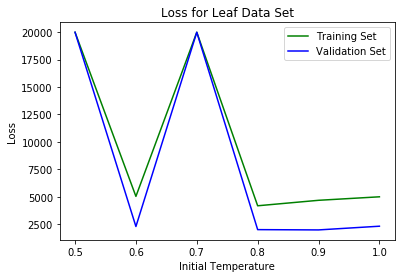

In [74]:
plt.plot(starting_point,np.array(train),'g',label='Training Set')
plt.plot(starting_point,np.array(val),'b',label='Validation Set')
plt.xlabel('Initial Temperature')
plt.ylabel('Loss')
plt.title('Loss for Leaf Data Set')
plt.legend()
plt.show()

In [75]:
print(train)
print(val)

[20000.0, 5029.4793528230784, 20000.0, 4172.8368899467696, 4671.5803426565353, 4990.5600948582251]
[20000.0, 2282.7169955497952, 20000.0, 1996.9097373760078, 1970.7467269525216, 2309.0799162446065]


# Ending Point

In [76]:
starting_point = np.arange(0.0,0.5,0.05)
ap = acceptance_probability
tf = temperature

train_3 = []
val_3 = []
for i in range(np.shape(starting_point)[0]):
    state, cfs,cost_val, states, costs, costs_val = annealing(random_start, nn_objective_train, random_neighbour, ap, tf, 5000, True,1,starting_point[i],10);
    train_3.append(np.min(costs))
    costs_val = np.array(costs_val)
    costs_val[np.isnan(costs_val)]=20000
    val_3.append(np.min(costs_val))

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


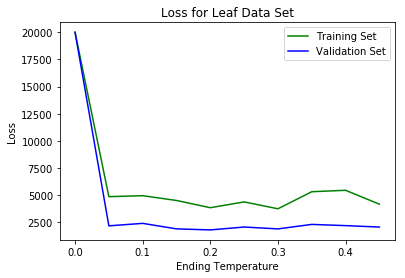

In [133]:
train_3[0]=20000
plt.plot(starting_point,np.array(train_3),'g',label='Training Set')
plt.plot(starting_point,np.array(val_3),'b',label='Validation Set')
plt.xlabel('Ending Temperature')
plt.ylabel('Loss')
plt.title('Loss for Leaf Data Set')
plt.legend()
plt.show()


In [145]:
print(val_3)

[20000.0, 2185.5168522534755, 2414.4813571335344, 1906.8843976943549, 1811.6778410466904, 2076.9347802680054, 1906.2258645346596, 2318.4586803321381, 2206.4494345482422, 2074.9492844508613]


# Amplitude

In [166]:
f_use = np.arange(0.01,10,2)
ap = acceptance_probability
tf = temperature

train_4 = []
val_4 = []
for i in range(np.shape(f_use)[0]):
    state, cfs,cost_val, states, costs, costs_val = annealing(random_start, nn_objective_train, random_neighbour, ap, tf, 10000, True,1,0.01,f_use[i]);
    train_4.append(np.min(costs))
    costs_val = np.array(costs_val)
    costs_val[np.isnan(costs_val)]=20000
    val_4.append(np.min(costs_val))

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


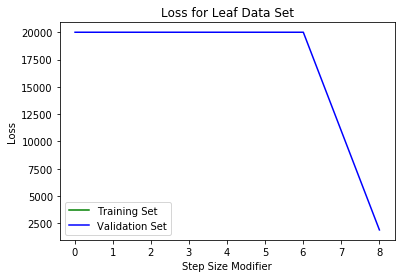

In [167]:

plt.plot(f_use,np.array(train_4),'g',label='Training Set')
plt.plot(f_use,np.array(val_4),'b',label='Validation Set')
plt.xlabel('Step Size Modifier')
plt.ylabel('Loss')
plt.title('Loss for Leaf Data Set')
plt.legend()
plt.show()

# Grid Search

In [80]:
sp = np.array([0.7,0.8,0.9,1])
ep = np.arange(0.0,0.5,0.1)
f_use = np.arange(1,10,3)

ap = acceptance_probability
tf = temperature
p_all = []
for i in range(np.shape(sp)[0]):
    for j in range(np.shape(ep)[0]):
        for k in range(np.shape(f_use)[0]):
            state, cfs,cost_val, states, costs, costs_val = annealing(random_start, nn_objective_train, random_neighbour, ap, tf, 10000,True,sp[i],ep[j],f_use[k])
            p_all.append(np.array([sp[i],ep[j],f_use[k],np.min(costs),np.min(costs_val)]))

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


In [81]:
print(np.shape(p_all))
all_vals = np.reshape(p_all,(60,5))
val_loss = all_vals[:,-1]
val_loss[np.isnan(val_loss)]=100000
b_idx = np.argmin(val_loss)
b_vals = all_vals[b_idx,:]
print(b_vals)

(60, 5)
[  9.00000000e-01   4.00000000e-01   7.00000000e+00   4.38475956e+03
   1.66448572e+03]


In [142]:
sp = p_all[0]
ep = p_all[1]
f_use = p_all[2]

# sp = np.array([0.8])
# ep =np.array([0.2])
# f_use = np.array([4])

ap = acceptance_probability
tf = temperature

# for i in range(np.shape(sp)[0]):
#     for j in range(np.shape(ep)[0]):
#         for k in range(np.shape(f_use)[0]):
state, cfs,cost_val, states, costs, costs_val = annealing(random_start, nn_objective_train, random_neighbour, ap, tf, 10000,True,sp[0],ep[0],f_use[0])


C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


5093.02224004
2322.91467189


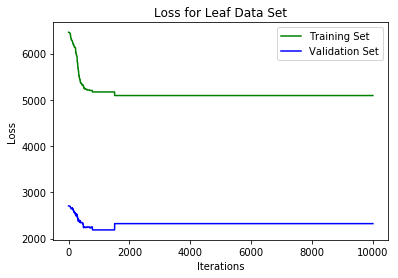

In [144]:
plt.plot(costs,'g',label='Training Set')
plt.plot(costs_val,'b',label='Validation Set')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss for Leaf Data Set')
plt.legend()
print(cfs)
print(cost_val)

In [117]:
def nn_objective_train(x_u):
    num_inputs = 14
    num_outputs = 36

    hidden_layer_neurons = 405
    x = x_u[0]
    weights_all = num_inputs*hidden_layer_neurons + hidden_layer_neurons*num_outputs
    bias_all = hidden_layer_neurons+num_outputs
    iw_size = num_inputs*hidden_layer_neurons
    nn_weights = x[:weights_all]
    bias_all = x[weights_all:]
    iw = nn_weights[0:iw_size]
    ow = nn_weights[iw_size:]
    b1 = bias_all[:hidden_layer_neurons]
    b2 = bias_all[hidden_layer_neurons:]
    w1 = np.reshape(iw,(num_inputs, hidden_layer_neurons))
    w2 = np.reshape(ow,(hidden_layer_neurons, num_outputs))
    l1 = np.maximum(np.dot(trainX, w1)+b1, 0)
    x_i = np.dot(l1, w2)+b2
    l2 = np.array(np.exp(x_i)/ np.exp(x_i).sum(axis=1)[:,None])  
    l2_act = np.argmax(l2,axis=1)+1
    output = np.clip(l2, 1e-15, 1. - 1e-15)
    er= -np.sum(trainY * np.log(output))
    predict_out = l2_act
    predict_out = predict_out.flatten()
    acc = 1-accuracy_score(trainY_comp,predict_out)
    print(acc)
    return er

def nn_objective_val(x_u):
    num_inputs = 14
    num_outputs = 36

    hidden_layer_neurons = 405
    x = x_u[0]
    weights_all = num_inputs*hidden_layer_neurons + hidden_layer_neurons*num_outputs
    bias_all = hidden_layer_neurons+num_outputs
    iw_size = num_inputs*hidden_layer_neurons
    nn_weights = x[:weights_all]
    bias_all = x[weights_all:]
    iw = nn_weights[0:iw_size]
    ow = nn_weights[iw_size:]
    b1 = bias_all[:hidden_layer_neurons]
    b2 = bias_all[hidden_layer_neurons:]
    w1 = np.reshape(iw,(num_inputs, hidden_layer_neurons))
    w2 = np.reshape(ow,(hidden_layer_neurons, num_outputs))
    l1 = np.maximum(np.dot(trainX_val, w1)+b1, 0)
    x_i = np.dot(l1, w2)+b2
    l2 = np.array(np.exp(x_i)/ np.exp(x_i).sum(axis=1)[:,None])  
    l2_act = np.argmax(l2,axis=1)+1
    output = np.clip(l2, 1e-15, 1. - 1e-15)
    er= -np.sum(trainY_val * np.log(output))
    predict_out = l2_act
    predict_out = predict_out.flatten()
    acc = 1-accuracy_score(trainY_comp_val,predict_out)
    print(acc)
    return er

def nn_objective_test(x_u):
    num_inputs = 14
    num_outputs = 36

    hidden_layer_neurons = 405
    x = x_u[0]
    weights_all = num_inputs*hidden_layer_neurons + hidden_layer_neurons*num_outputs
    bias_all = hidden_layer_neurons+num_outputs
    iw_size = num_inputs*hidden_layer_neurons
    nn_weights = x[:weights_all]
    bias_all = x[weights_all:]
    iw = nn_weights[0:iw_size]
    ow = nn_weights[iw_size:]
    b1 = bias_all[:hidden_layer_neurons]
    b2 = bias_all[hidden_layer_neurons:]
    w1 = np.reshape(iw,(num_inputs, hidden_layer_neurons))
    w2 = np.reshape(ow,(hidden_layer_neurons, num_outputs))
    l1 = np.maximum(np.dot(testX, w1)+b1, 0)
    x_i = np.dot(l1, w2)+b2
    l2 = np.array(np.exp(x_i)/ np.exp(x_i).sum(axis=1)[:,None])  
    l2_act = np.argmax(l2,axis=1)+1
    output = np.clip(l2, 1e-15, 1. - 1e-15)
    er= -np.sum(testY * np.log(output))
    predict_out = l2_act
    predict_out = predict_out.flatten()
    acc = 1-accuracy_score(testY_comp,predict_out)
    print(acc)
    return er

In [118]:
idx = np.argmin(costs_val)
w = states[idx]

print(nn_objective_train(w))
print(nn_objective_val(w))
print(nn_objective_test(w))


0.884210526316
4643.40484033
0.841463414634
2027.22280538
0.926470588235
1691.14099104
